In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt

import numpy as np

# Studying information geometric applications for mixture families

## Example of mixture family
Gauss:
$p_0(x;\mu, \sigma) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2 \sigma^2}\right)$

Cauchy:
$p_1(x;\mu, \gamma) = \frac{1}{\pi} \frac{\gamma}{\gamma^2 + (x - \mu)^2}$

Laplace:
$p_2(x;\mu, b) = \frac{1}{2b} \exp\left( -\frac{|x-\mu|}{b} \right)$


$\rightarrow m(x; \eta) = \eta_1 p_1 + \eta_2 p_2 + (1-\eta_1-\eta_2) p_0$

In [2]:
plt.rcParams["figure.figsize"] = (10,8)

def gauss(x, mu, sigma):
    return np.exp(-((x - mu)**2) / (2 * sigma**2)) * (1 / (sigma * np.sqrt(2 * np.pi)))

def laplace(x, mu, b):
    return np.exp(-abs(x - mu) / b) / (2 * b)

def cauchy(x, mu, gamma):
    return 1/np.pi * gamma / ((x - mu)**2 + gamma**2)

def m(X, m1, m2):
    return m1*cauchy(X, 0, 1) + m2*laplace(X, 3, 1) + (1-m1-m2)*gauss(X, -3, 1)

X = np.linspace(-7, 7, 200)
def f(m1, m2 ):
    plt.plot(X, gauss(X, -3, 1), label='$p_0$ gauss')
    plt.plot(X, cauchy(X, 0, 1), label='$p_2$ cauchy')
    plt.plot(X, laplace(X, 3, 1), label='$p_3$ laplace')
    plt.plot(X, m(X, m1, m2), 'black', label='mixture')
    plt.legend()

# interact with sliders
interact(f, m1=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.33), m2=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.33));


interactive(children=(FloatSlider(value=0.33, description='m1', max=1.0, step=0.01), FloatSlider(value=0.33, d…

#### Estimating $B_G$

Notice that $F$ in our case is the ideal negative Shannon entropy:
$$G(\eta) = -h(m(x;\eta)) = \int_{x \in \mathcal{X}} m(x;\eta) \log m(x;\eta) \text{d} \mu (x)$$

We however want to estimate it by using a finite data $S \subset \mathcal{X}$:

$$G(\eta) \approx \tilde{G}_S (\eta) = \frac{1}{m} \sum_{i=1}^m \frac{1}{q(x_i)} \, m(x_i;\eta) \log m(x_i;\eta) $$
where $m= |S|$ and $q(x)$ is the fixed proposal distribution. 

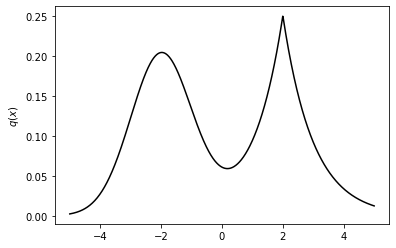

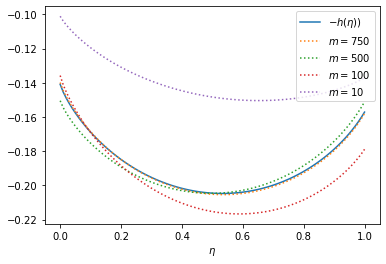

In [3]:
plt.rcParams["figure.figsize"] = (6,4)
def m(X, eta):
    return (1-eta)*gauss(X, -2,1) + eta*laplace(X, 2, 1)

def shannon_negentropy(X, eta):
    results = []
    for e in eta:
        results.append(np.sum(m(X, e)*np.log(m(X, e)))/len(X))
    return results

def mc_G(X, eta, eta_q):
    results = []
    for e in eta:
        r = np.sum(m(X, e)*np.log(m(X, e))/m(X,eta_q))/len(X)
        results.append(r)
    return results

def reduce_to_N_supports(X, N):
    import random
    random.shuffle(X)
    return X[:N]


eta_q = 0.5

X = np.linspace(-5,5,1000)
plt.plot(X, m(X, eta_q), 'black')
plt.ylabel('$q(x)$')
plt.show()

eta = np.linspace(0,1,100)
plt.plot(eta, shannon_negentropy(X, eta), label="$-h(\eta)$)")
plt.plot(eta, shannon_negentropy(reduce_to_N_supports(X, 750), eta),":", label="$m=750$")
plt.plot(eta, shannon_negentropy(reduce_to_N_supports(X, 500), eta),":", label="$m=500$")
plt.plot(eta, shannon_negentropy(reduce_to_N_supports(X,100), eta),":", label="$m=100$")
plt.plot(eta, shannon_negentropy(reduce_to_N_supports(X,10), eta),":", label="$m=10$")
plt.legend()
plt.xlabel("$\eta$")
plt.show();

### Bregman Voronoi clustering
To approximate the dual coordinate system $\theta$ we use
$$\theta_1 = \partial_1 G(\eta) \approx \partial_1 \tilde{G}_S (\eta) = \frac{1}{m} \sum_{i=1}^m \frac{1}{q(x_i)}(p_1(x_i)-p_0(x_i)) (1+\log m(x_i;\eta)) $$
$$\theta_2 = \partial_2 G(\eta) \approx \partial_2 \tilde{G}_S (\eta) = \frac{1}{m} \sum_{i=1}^m \frac{1}{q(x_i)}(p_2(x_i)-p_0(x_i)) (1+\log m(x_i;\eta)) $$

Then we draw a Laguerre-Voronoi diagram, according to https://arxiv.org/pdf/0709.2196.pdf (4.3)
$$<x-\theta, x-\theta> = <\theta, \theta> + 2(\tilde{G}_S(\eta) - <\eta, \theta>)$$ 
which in turn leads to the wanted Voronoi diagram for our mixture in $\eta$ coordinates.


We draw the Laguerre-Voronoi diagram using a tool from github: https://gist.github.com/marmakoide/45d5389252683ae09c2df49d0548a627#file-laguerre-voronoi-2d-py

(16, 2) (16,)


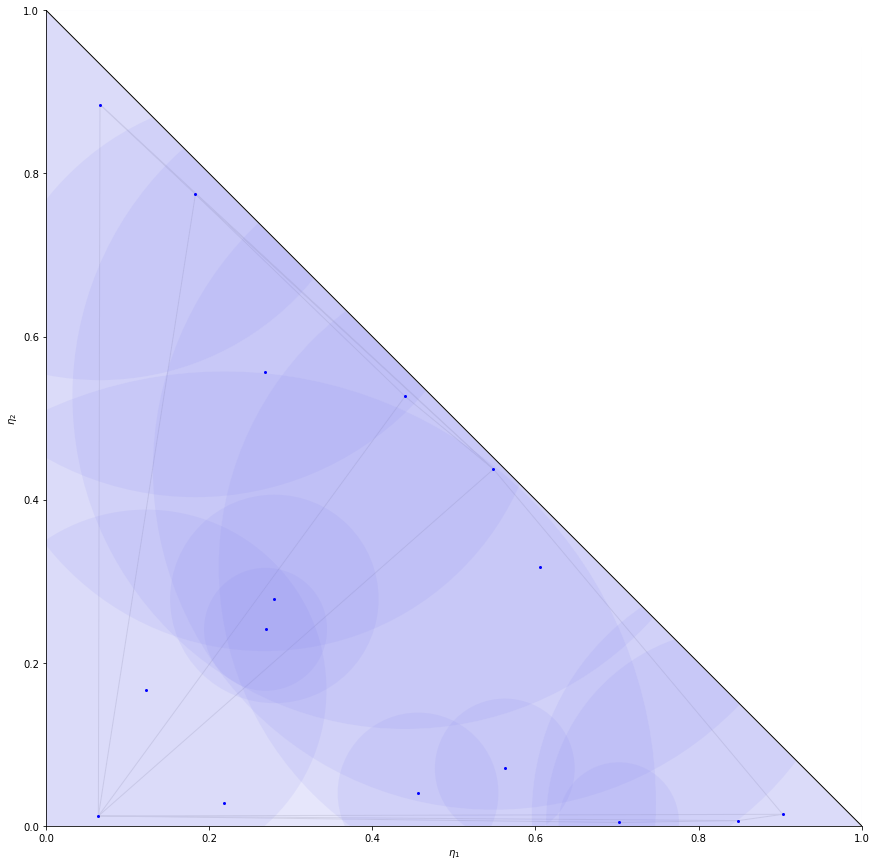

In [66]:
plt.rcParams["figure.figsize"] = (15,15)

def p1(X):
    return cauchy(X, 0, 1)

def p0(X):
    return gauss(X, -3, 1)

def p2(X):
    return laplace(X, 3, 1)

def m(X, eta):
    return eta[0]*p1(X) + eta[1]*p2(X) + (1-eta[0]-eta[1])*p0(X)

"""In practice, the proposal distribution q(x) can be chosen as the uniform mixture of the fixed component
distributions"""
def q(X):    
    return m(X, [1/3, 1/3])

# eta is a vector of length 2 now!
def mc_G(X, eta):
    return np.sum(m(X, eta)*np.log(m(X, eta))/q(X))/len(X)


def mc_dG(X, eta):
    """Derivative of G to get dual coordinates: theta = dG(eta)"""
    dG1 = np.sum(1/q(X) * (p1(X)-p0(X)) * (1+np.log(m(X,eta))) )/len(X)
    dG2 = np.sum(1/q(X) * (p2(X)-p0(X)) * (1+np.log(m(X,eta))) )/len(X)
    return [dG1,dG2]

# generate example mixtures
N = 16
eta1 = np.random.uniform(0,1,N)
eta2 = np.random.uniform(0,1-eta1,N)
eta = np.array([eta1, eta2]).transpose()

# get theta from derivatives of G
theta = np.array([mc_dG(X, [eta1[i], eta2[i]]) for i in range(N)])


weights = np.array([( np.inner(theta[i], theta[i]) 
                     + 2*(mc_G(X,eta[i]) -np.inner(theta[i], eta[i])) 
                    ) for i in range(N)])
weights /= np.sum(weights)


import importlib  
lv = importlib.import_module("laguerre-voronoi-2d")
lv = importlib.reload(lv)


print(eta.shape, weights.shape)
tri_list, V = lv.get_power_triangulation(eta, weights)

#compute the voronoi cells
voronoi_cell_map = lv.get_voronoi_cells(eta, V, tri_list)


ax = plt.subplot(111)
plt.xlabel("$\eta_1$")
plt.ylabel("$\eta_2$")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.gca().set_aspect('equal', adjustable='box')
plt.axline((1, 0), (0, 1), color="black", linewidth=1)


for i in range(len(eta1)):
    plt.plot(eta1[i], eta2[i], 'o', markersize=2, color="blue")

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# display laguerre-voronoi diagram
lv.display(eta, weights, tri_list, voronoi_cell_map, ax)

#cover accidents:
t = plt.Polygon(np.array([[1,0],[0,1],[1,1]]), color="white")
plt.gca().add_patch(t)

plt.show();

### Actual clustering with Bregmann k-Means

We will now cluster $N=16$ mixtures into $k=3$ clusters, using again the MC Bregmann divergence $B_{\tilde{G}_S}$ instead of a euclidian distance for the distance function in the k-Means algorithm.
https://sites.math.washington.edu/~morrow/papers/julie-thesis.pdf

In [70]:

# how many clusters?
k = 4

# generate mixtures we want to cluster
N = 20
eta1 = np.random.uniform(0,1,N)
eta2 = np.random.uniform(0,1-eta1,N)
eta = np.array([eta1, eta2]).transpose()

# get theta from derivatives of G
theta = np.array([mc_dG(X, [eta1[i], eta2[i]]) for i in range(N)])


# initialize random means similarly
e_mu1 = np.random.uniform(0,1,k)
e_mu2 = np.random.uniform(0,1-e_mu1,k)
e_mu = np.array([e_mu1, e_mu2]).transpose()

def B_G(eta1, eta2, theta2):
    return mc_G(X, eta1) - mc_G(X, eta2) - np.inner(theta2, eta1-eta2)

optimal = False
restart = True
opt_cluster = None
while restart:
    while not optimal:
        cluster = [ []  for _ in range(k) ]
        for i in range(N):
            # get nearest mean using bregmann divergence
            #h = np.argmin([B_G(eta[i], e_mu[j], mc_dG(X, [e_mu[j,0], e_mu[j,1]])) for j in range(k)])
            h = np.argmin([B_G(e_mu[j], eta[i], mc_dG(X, [eta[i,0], eta[i,1]])) for j in range(k)])
            cluster[h].append(eta[i])
        
        old = e_mu.copy() # for checking if it will change
        
        for h in range(k):
            # Estimation step (E-step)
            # when cluster is empty, break out of loop
            if len(cluster[h]) == 0:
                break
            e_mu[h] = np.mean(np.array(cluster[h]), axis=0)
            #e_mu[h] = np.mean(np.array(cluster[h]), axis=0)
        if (e_mu==old).all():
            optimal = True
            restart = False
            opt_cluster = cluster
            break



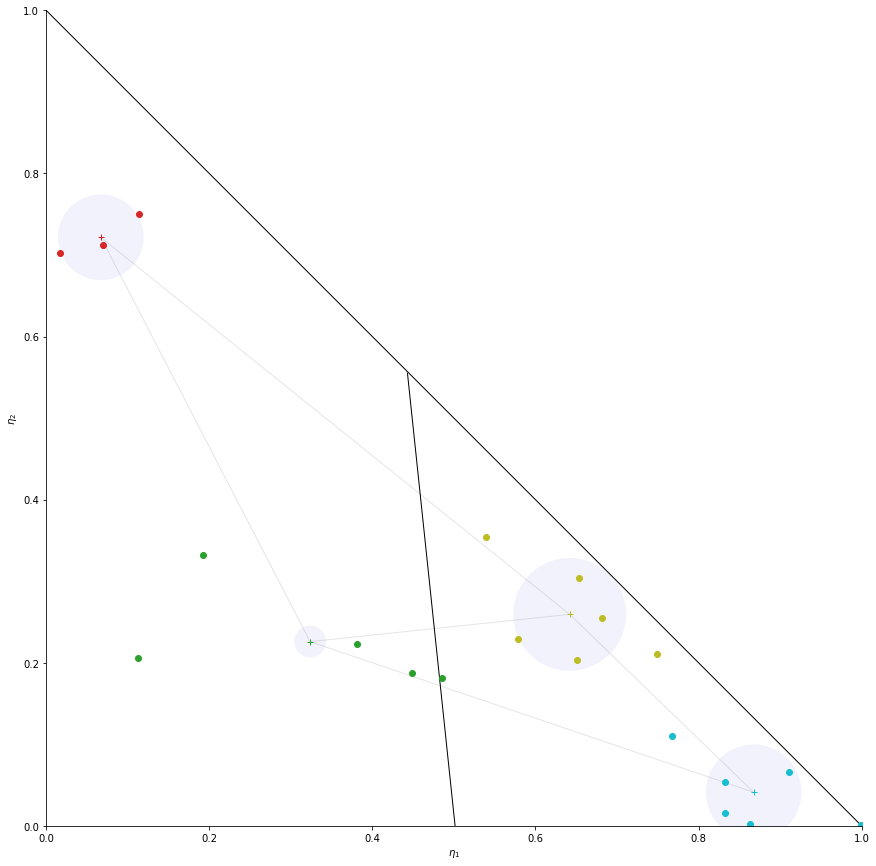

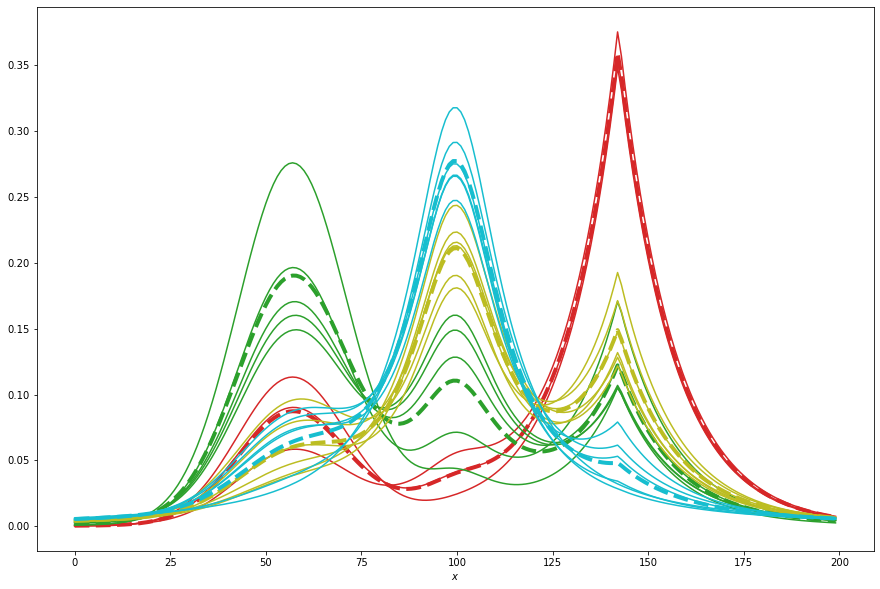

In [71]:
plt.rcParams["figure.figsize"] = (15,15)
ax = plt.subplot(111)
plt.xlabel("$\eta_1$")
plt.ylabel("$\eta_2$")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.gca().set_aspect('equal', adjustable='box')
plt.axline((1, 0), (0, 1), color="black", linewidth=1)

colors = ["tab:red", "tab:green", "tab:olive", "tab:cyan", "tab:brown", "tab:pink", "tab:gray", "tab:blue"]
for h in range(len(opt_cluster)):
    for eta_cat in opt_cluster[h]:
        plt.plot(eta_cat[0], eta_cat[1], 'o', color=colors[h])
    plt.plot(e_mu[h][0], e_mu[h][1], '+', color=colors[h])
    

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

#cover accidents:
t = plt.Polygon(np.array([[1,0],[0,1],[1,1]]), color="white")
plt.gca().add_patch(t)

t_mu = np.array([mc_dG(X, e_mu[h]) for h in range(k)])


weights = np.array([( np.inner(t_mu[h], t_mu[h]) 
                     + 2*(mc_G(X,e_mu[h]) -np.inner(t_mu[h], e_mu[h])) 
                    ) for h in range(k)])
weights /= np.sum(weights)*5
#weights /= np.sum(weights)

tri_list, V = lv.get_power_triangulation(e_mu, weights)

#compute the voronoi cells
voronoi_cell_map = lv.get_voronoi_cells(e_mu, V, tri_list)
#display laguerre-voronoi diagram
lv.display(e_mu, weights, tri_list, voronoi_cell_map, ax)

#cover accidents:
t = plt.Polygon(np.array([[1,0],[0,1],[1,1]]), color="white")
plt.gca().add_patch(t)
plt.savefig("mixture_clustering_eta_space.pdf")
plt.show();

plt.rcParams["figure.figsize"] = (15,10)
X = np.linspace(-7, 7, 200)

for h in range(len(opt_cluster)):
    for eta_cat in opt_cluster[h]:
        plt.plot(m(X, eta_cat), color=colors[h])
    plt.plot(m(X, e_mu[h]),"--", linewidth=4, color=colors[h])
plt.xlabel("$x$")
plt.savefig("mixture_clustering.pdf")
plt.show();


